# Normalization Plots

### Imports

In [3]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import warnings
warnings.simplefilter("ignore")

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [4]:
trail_size=14
predict_length = 5
time_period = '6y'

# 1.0 Load data

In [5]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [6]:
traditional_energy_stocks = [
    "LNG",
    "OKE",
    "BKR",
    "WMB",
    "EQT", 
    "XEC", 
    "XOM", 
    "CVX", 
    "BP", 
    "OXY", 
    "COP", 
    "EOG", 
    "COG", 
    "CNQ", 
    "SLB", 
    "PTR", 
    "TOT", 
    "ENB",  
]

In [7]:
data = get_data_yf(traditional_energy_stocks, time_period)

[*********************100%***********************]  18 of 18 completed


In [8]:
data.isna().sum().sum()

0

In [9]:
data = process_stock_data_from_yf(data)

In [10]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

In [11]:
### Compute technical indicators

In [12]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

In [13]:
### Load climate trends data

In [14]:
filenames = [os.path.join("data", x) for x in [
    "data climate change adjusted.csv",
    "data greenhouse gas adjusted.csv",
    "data oil adjusted.csv",
    "data renewable adjusted.csv",
    "data carbon tax adjusted.csv",
    "data electric vehicles adjusted.csv",
    "data environmental protection agency adjusted.csv",
    "data fossil fuels adjusted.csv",
    "data fracking adjusted.csv",
    "data global warming adjusted.csv",
] ]
terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
    "environmental protection agency",
    "fossil fuels",
    "fracking",
    "global warming",
]

In [15]:
climate_trends_data = load_climate_data(filenames, terms)

In [16]:
climate_trends_data.shape

(2278, 11)

In [17]:
num_climate_features = len(climate_trends_data.columns.tolist()) - 1 # minus date

<AxesSubplot:xlabel='Date'>

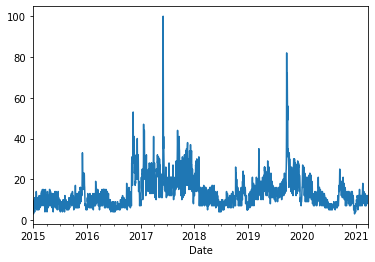

In [18]:
climate_trends_data.set_index('Date')['climate change'].plot()

# 2.0 Prepare dataset of many stocks

### Choose technical features

In [19]:
features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']
dataset = dataset[['Ticker', 'Date'] + features]
num_features = len(features)

### Train test split

In [20]:
train = dataset.loc[dataset['Date'] < "2018-03-01"]
valid = dataset.loc[(dataset['Date'] > "2018-03-13") & (dataset['Date'] < "2019-03-01")]
test = dataset.loc[(dataset['Date'] > "2019-03-01") & (dataset['Date'] < "2020-03-01")]

In [21]:
train.shape

(13194, 31)

In [22]:
test.shape

(4518, 31)

### Without normalization

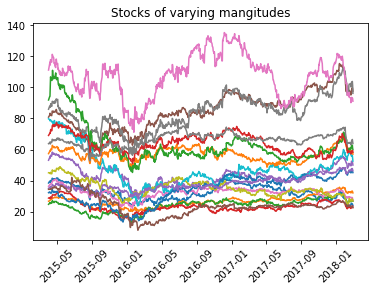

In [23]:
tickers = train['Ticker'].unique()
for ticker in tickers:
    x = train.loc[train['Ticker']==ticker, "Date"]
    y = train.loc[train['Ticker']==ticker, "Close"]
    
    plt.plot(x, y, label=ticker, )
    plt.title("Stocks of varying mangitudes")
    plt.xticks(rotation=45)

### Global stock normalization

In [24]:
m = MinMaxScaler()
train2 = train.copy()
train2[features] = m.fit_transform(train2[features])


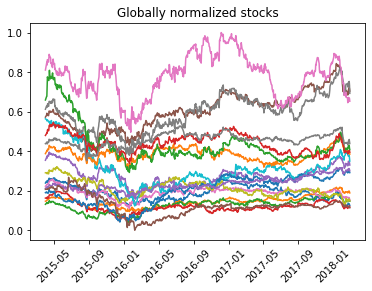

In [25]:
tickers = train2['Ticker'].unique()
for ticker in tickers:
    x = train2.loc[train2['Ticker']==ticker, "Date"]
    y = train2.loc[train2['Ticker']==ticker, "Close"]
    
    plt.plot(x, y, label=ticker )
    plt.title("Globally normalized stocks")
    plt.xticks(rotation=45)

### Per stock normalization
We make sure to fit the transforms on the training, and
apply them on training, validation, and test

In [26]:
scaler_models = norm_per_stock_split(train, valid, test, features, MinMaxScaler)

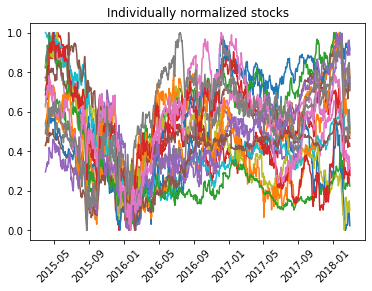

In [27]:
tickers = train['Ticker'].unique()
for ticker in tickers:
    x = train.loc[train['Ticker']==ticker, "Date"]
    y = train.loc[train['Ticker']==ticker, "Close"]
    
    plt.plot(x, y, label=ticker, )
    plt.title("Individually normalized stocks")
    plt.xticks(rotation=45)